#### Analyzing Neural Time Series Data
Python code for Chapter 31 -- converted from original Matlab by AE Studio (and ChatGPT)\
Original Matlab code by Mike X Cohen

This code accompanies the book, titled "Analyzing Neural Time Series Data" (MIT Press).\
Using the code without following the book may lead to confusion, incorrect data analyses, and misinterpretations of results.\
Mike X Cohen and AE Studio assume no responsibility for inappropriate or incorrect use of this code.

In [49]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as loadmat
from scipy.fft import fft, ifft
from scipy.signal import hilbert
from scipy.stats import norm
from mne.viz import plot_topomap
import networkx as nx

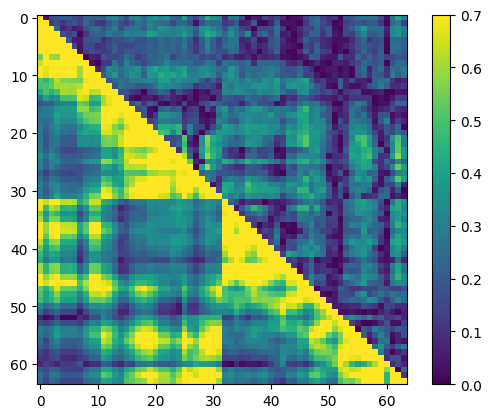

In [3]:
# Figure 31.2


# Load data
data = loadmat('../data/sampleEEGdata.mat')
EEG = data['EEG'][0, 0]

# Specify some time-frequency parameters
center_freq = 10  # Hz
time2analyze = 200  # in ms

# Wavelet and FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0, 0], 1/EEG['srate'][0, 0])
half_wavelet = (len(time) - 1) // 2
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1

# Initialize connectivity output matrix
connectivitymat = np.zeros((EEG['nbchan'][0, 0], EEG['nbchan'][0, 0]))

# Time in indices
tidx = np.argmin(np.abs(EEG['times'][0] - time2analyze))

# Create wavelet and take FFT
s = 5 / (2 * np.pi * center_freq)
wavelet_fft = fft(np.exp(2 * 1j * np.pi * center_freq * time) * np.exp(-time**2 / (2 * (s**2))), n_convolution)

# Compute analytic signal for all channels
analyticsignals = np.zeros((EEG['nbchan'][0, 0], EEG['pnts'][0, 0], EEG['trials'][0, 0]), dtype=complex)
for chani in range(EEG['nbchan'][0, 0]):
    # FFT of data
    data_fft = fft(EEG['data'][chani].flatten('F'), n_convolution)
    
    # Convolution
    convolution_result = ifft(wavelet_fft * data_fft, n_convolution)
    convolution_result = convolution_result[half_wavelet:-half_wavelet]
    
    analyticsignals[chani] = np.reshape(convolution_result, (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')

# Now compute all-to-all connectivity
for chani in range(EEG['nbchan'][0, 0]):
    for chanj in range(chani, EEG['nbchan'][0, 0]):  # Note that you don't need to start at 1
        xsd = analyticsignals[chani, tidx] * np.conj(analyticsignals[chanj, tidx])
        
        # Connectivity matrix (phase-lag index on upper triangle; ISPC on lower triangle)
        connectivitymat[chani, chanj] = np.abs(np.mean(np.sign(np.imag(xsd))))
        connectivitymat[chanj, chani] = np.abs(np.mean(np.exp(1j * np.angle(xsd))))

# Plotting the connectivity matrix
plt.figure()
plt.imshow(connectivitymat, aspect='equal', vmin=0, vmax=0.7)
plt.colorbar()
plt.show()

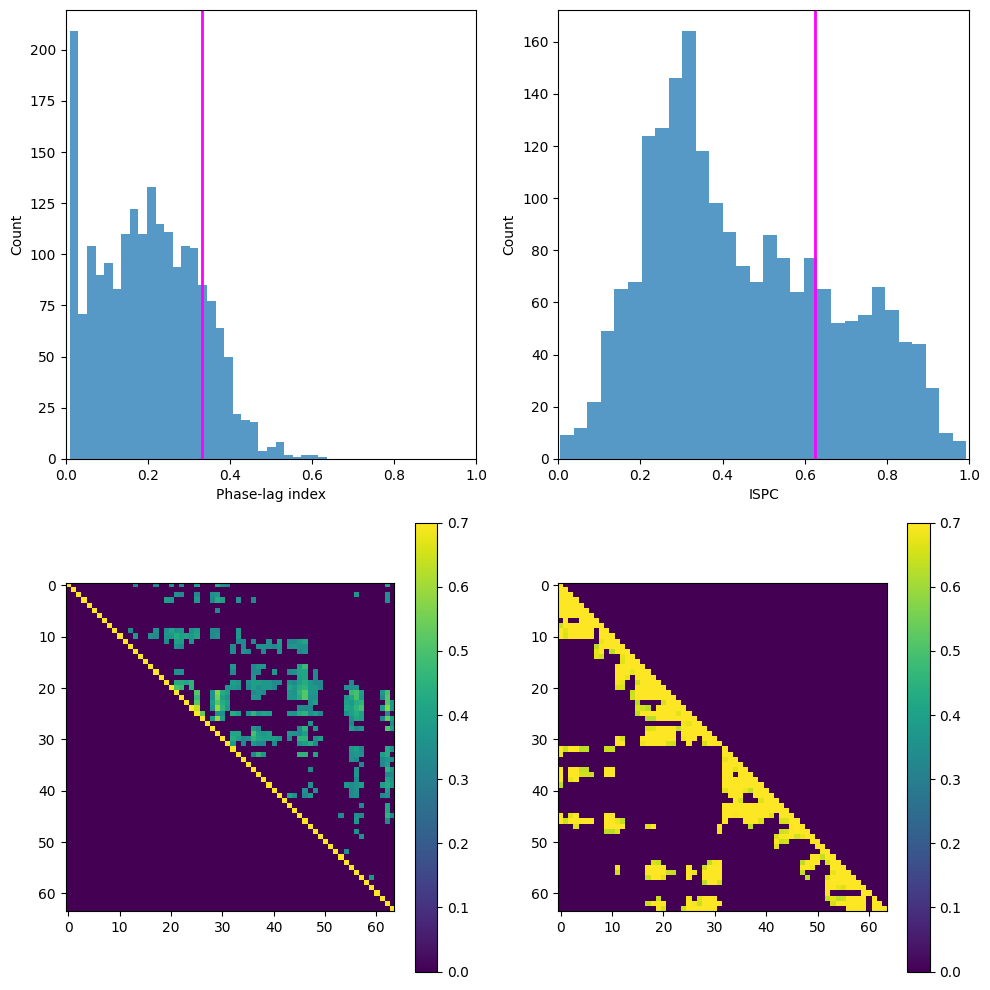

In [5]:
# Figure 31.4

plt.figure(figsize=(10, 10))

# Subplot 221
plt.subplot(221)
# Get upper part of matrix
temp = connectivitymat[np.triu_indices_from(connectivitymat, k=1)]
# Threshold is one std above median connectivity value
pli_thresh = np.std(temp) + np.median(temp)
# Plot histogram and vertical line at threshold
plt.hist(temp, bins=30, alpha=0.75)
plt.axvline(pli_thresh, color='magenta', linewidth=2)
plt.xlabel('Phase-lag index')
plt.ylabel('Count')
plt.xlim([0, 1])

# Subplot 222
plt.subplot(222)
# Get lower part of matrix
temp = connectivitymat[np.tril_indices_from(connectivitymat, k=-1)]
# Find 1 std above median connectivity value
ispc_thresh = np.std(temp) + np.median(temp)
# Plot histogram and vertical line at threshold
plt.hist(temp, bins=30, alpha=0.75)
plt.axvline(ispc_thresh, color='magenta', linewidth=2)
plt.xlabel('ISPC')
plt.ylabel('Count')
plt.xlim([0, 1])

# Subplot 223
plt.subplot(223)
# Make symmetric phase-lag index connectivity matrix
pli_mat = np.triu(connectivitymat)
pli_mat[pli_mat < pli_thresh] = 0
# Plot the matrix
plt.imshow(pli_mat, aspect='equal', vmin=0, vmax=0.7)
plt.colorbar()

# Subplot 224
plt.subplot(224)
# Make symmetric ISPC connectivity matrix
ispc_mat = np.tril(connectivitymat)
ispc_mat[ispc_mat < ispc_thresh] = 0
# Plot the matrix
plt.imshow(ispc_mat, aspect='equal', vmin=0, vmax=0.7)
plt.colorbar()

plt.tight_layout()
plt.show()

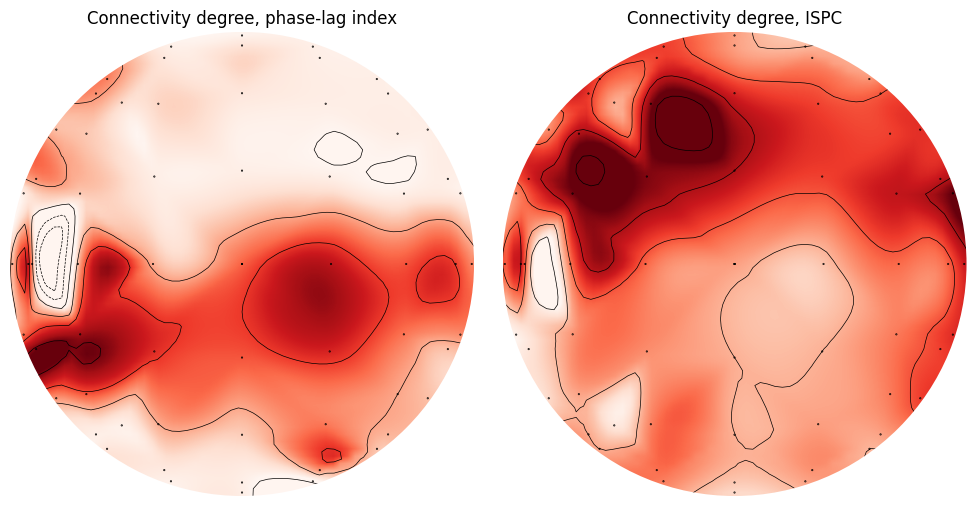

In [9]:
# Figure 31.6
plt.figure(figsize=(10, 5))

# Subplot 121
ax1 = plt.subplot(121)
# Note: logical() below converts the matrix to 0's and 1's
degree_pli = np.sum(pli_mat > 0, axis=0)
chanlocs = np.array([[x[0][0], y[0][0]] for x, y in zip(EEG['chanlocs'][0]['X'], EEG['chanlocs'][0]['Y'])])
# Plot topomap
plot_topomap(degree_pli, chanlocs, axes=ax1, show=False)
plt.title('Connectivity degree, phase-lag index')

# Subplot 122
ax2 = plt.subplot(122)
degree_ispc = np.sum(ispc_mat > 0, axis=0)
# Plot topomap
plot_topomap(degree_ispc, chanlocs, axes=ax2, show=False)
plt.title('Connectivity degree, ISPC')

plt.tight_layout()
plt.show()

In [13]:
# Figure 31.7 (analyses are here; next cell plots results)

frex = np.logspace(np.log10(3), np.log10(40), 25)
times2save = np.arange(-300, 1201, 50)
thresh = np.zeros(len(frex))  # Added threshold vector

# Wavelet and FFT parameters
time = np.arange(-1, 1 + 1/EEG['srate'][0, 0], 1/EEG['srate'][0, 0])
half_wavelet = (len(time) - 1) // 2
n_wavelet = len(time)
n_data = EEG['pnts'][0, 0] * EEG['trials'][0, 0]
n_convolution = n_wavelet + n_data - 1
n_conv2 = 2 ** (np.ceil(np.log2(n_convolution)).astype(int))

# Create wavelet (and take FFT)
wavelets_fft = np.zeros((len(frex), n_conv2), dtype=complex)
s = np.logspace(np.log10(4), np.log10(10), len(frex)) / (2 * np.pi * frex)
for fi in range(len(frex)):
    wavelets_fft[fi, :] = fft(np.exp(2 * 1j * np.pi * frex[fi] * time) * np.exp(-time**2 / (2 * (s[fi]**2))), n_conv2)

# Find time indices
times2saveidx = [np.argmin(np.abs(EEG['times'][0] - t)) for t in times2save]

# Initialize matrices
alldata = np.zeros((EEG['nbchan'][0, 0], len(frex), len(times2save), EEG['trials'][0, 0]), dtype=complex)
tf_all2all = np.zeros((EEG['nbchan'][0, 0], EEG['nbchan'][0, 0], len(frex), len(times2save)), dtype=complex)
tf_degree = np.zeros((EEG['nbchan'][0, 0], len(frex), len(times2save)))

# First, run convolution for all electrodes and save results
for chani in range(EEG['nbchan'][0, 0]):
    # FFT of activity at this electrode (note that this is done outside the frequency loop)
    eeg_fft = fft(EEG['data'][chani].flatten('F'), n_conv2)
    
    # Loop over frequencies
    for fi in range(len(frex)):
        # Analytic signal from target
        conv_res = ifft(wavelets_fft[fi, :] * eeg_fft, n_conv2)
        conv_res = conv_res[:n_convolution]
        asig = np.reshape(conv_res[half_wavelet:-half_wavelet], (EEG['pnts'][0, 0], EEG['trials'][0, 0]), 'F')
        
        # Store the required time points
        alldata[chani, fi, :, :] = asig[times2saveidx, :]

# Now that we have all the data, compute all-to-all connectivity
for chani in range(EEG['nbchan'][0, 0]):
    for chanj in range(chani + 1, EEG['nbchan'][0, 0]):
        # Compute connectivity
        xsd = alldata[chani] * np.conj(alldata[chanj])
        
        # Connectivity matrix (phase-lag index or ISPC; comment one or the other line)
        # tf_all2all[chani, chanj] = np.abs(np.mean(np.sign(np.imag(xsd)), axis=2))  # PLI
        tf_all2all[chani, chanj] = np.abs(np.mean(np.exp(1j * np.angle(xsd)), axis=2))  # ISPC

# Now that we have a one-to-all connectivity, threshold the connectivity matrix
# (separate threshold for each frequency)
for fi in range(len(frex)):
    # Use the absolute values (magnitudes) of the complex numbers for thresholding
    tempsynch = np.abs(tf_all2all[:, :, fi, :].flatten('F'))
    thresh[fi] = np.median(tempsynch) + np.std(tempsynch)
    
    # Isolate, threshold, binarize
    for ti in range(tf_all2all.shape[3]):
        temp = np.abs(tf_all2all[:, :, fi, ti])  # Use the magnitude for thresholding
        temp = temp + temp.T  # Make symmetric matrix
        temp = temp > thresh[fi]  # Threshold and binarize
        tf_degree[:, fi, ti] = np.sum(temp, axis=0)  # Compute degree

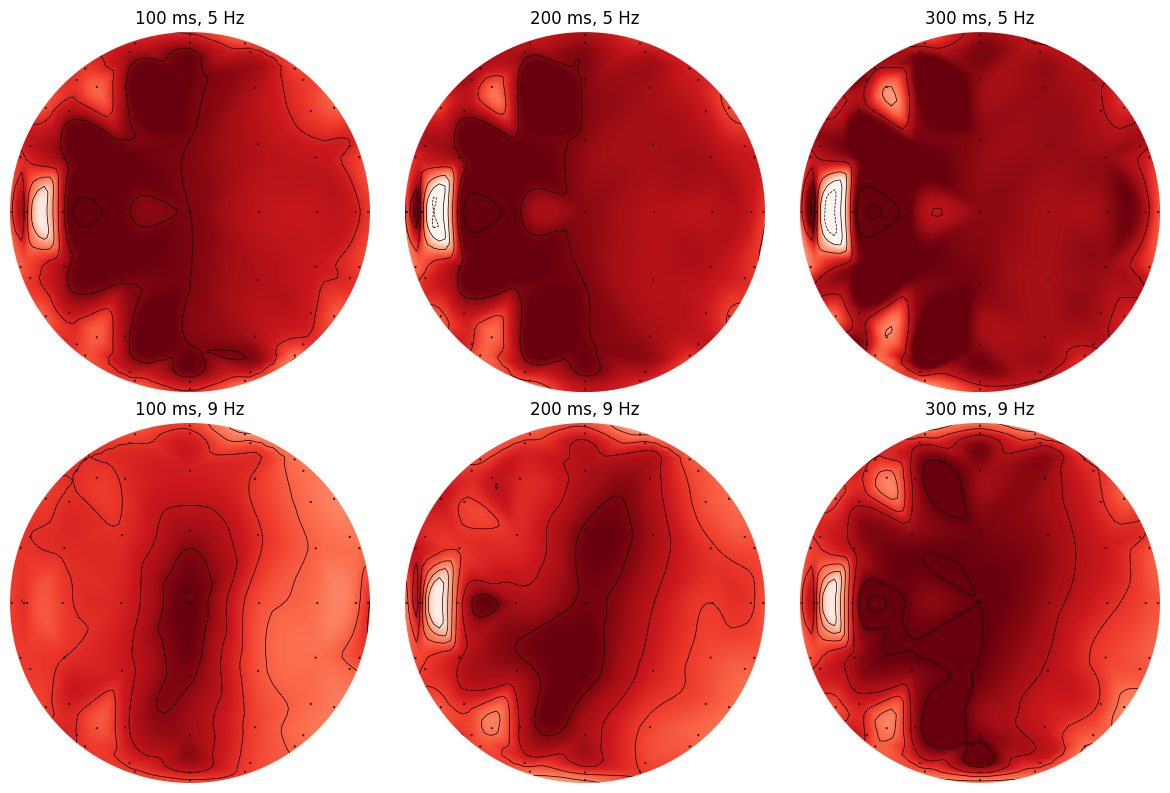

In [17]:
# Figure 31.7 (plotting)

# Show topographical maps
freqs2plot = [5, 9]  # Hz
times2plot = [100, 200, 300]  # ms
clim = [0, 20]

plt.figure(figsize=(12, 8))
for fi, freq in enumerate(freqs2plot):
    for ti, time in enumerate(times2plot):
        plt_idx = ti + 1 + fi * len(times2plot)
        ax = plt.subplot(len(freqs2plot), len(times2plot), plt_idx)
        freq_idx = np.argmin(np.abs(frex - freq))
        time_idx = np.argmin(np.abs(times2save - time))
        plot_topomap(tf_degree[:, freq_idx, time_idx], chanlocs, axes=ax, show=False)
        plt.title(f"{time} ms, {freq} Hz")

plt.tight_layout()
plt.show()

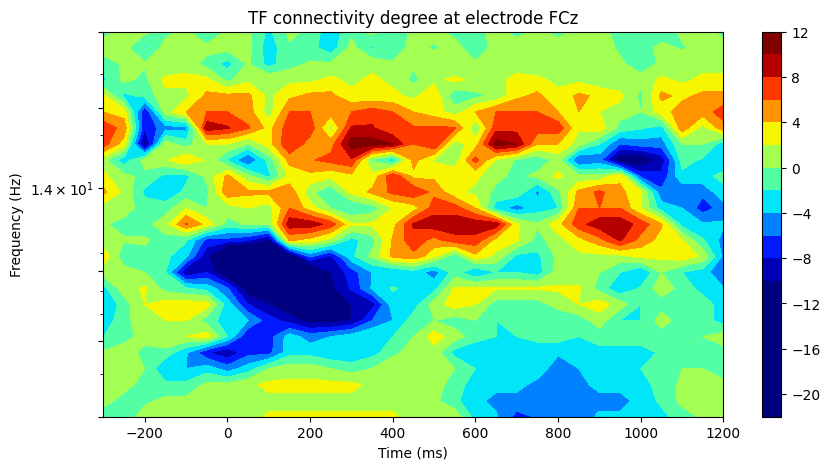

In [23]:
# Figure 31.8

electrode2plot = 'FCz'  # Change to 'oz' or any other electrode as needed
baselineperiod = [-300, -100]
clim = [-10, 10]

# Convert baseline period time to indices
baseidx = [np.argmin(np.abs(times2save - t)) for t in baselineperiod]
# Subtract baseline
tf_degree_base = tf_degree - np.mean(tf_degree[:, :, baseidx[0]:baseidx[1]], axis=2, keepdims=True)

# Find the index of the electrode to plot
electrode_idx = EEG['chanlocs'][0]['labels']==electrode2plot

# Extract the 2D data for the specific electrode
tf_degree_base_2d = tf_degree_base[electrode_idx, :, :][0]

plt.figure(figsize=(10, 5))
# Contourf plot for time-frequency connectivity degree at the specified electrode
# Note that we are now using the 2D slice for the contour plot
plt.contourf(times2save, frex, tf_degree_base_2d, 20, cmap='jet')
plt.colorbar()
plt.clim(clim)
plt.yscale('log')
plt.yticks(np.round(np.logspace(np.log10(frex[0]), np.log10(frex[-1]), 6)))
plt.xlabel('Time (ms)')
plt.ylabel('Frequency (Hz)')
plt.title(f'TF connectivity degree at electrode {electrode2plot}')

plt.show()

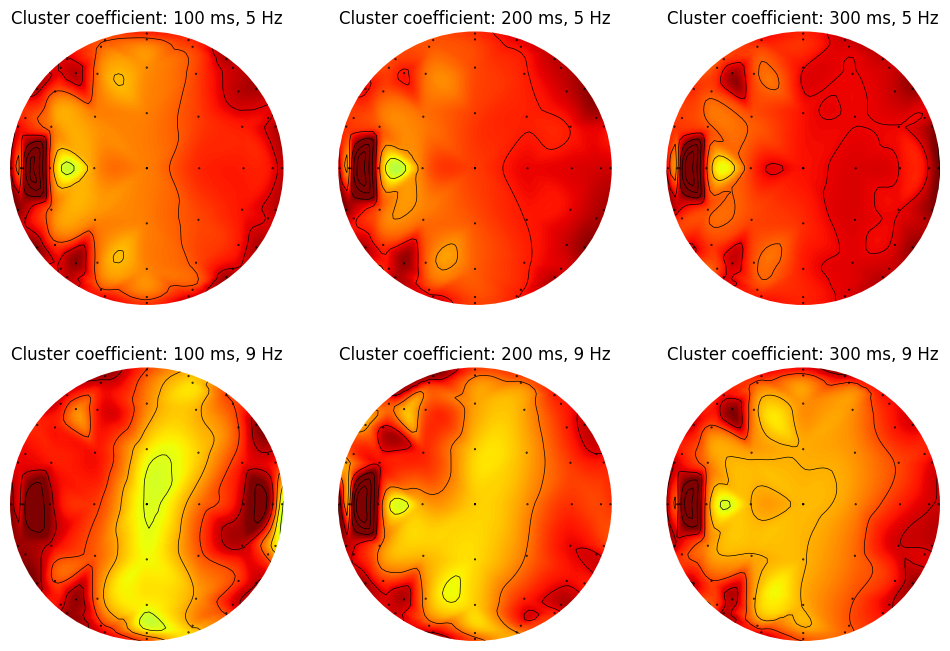

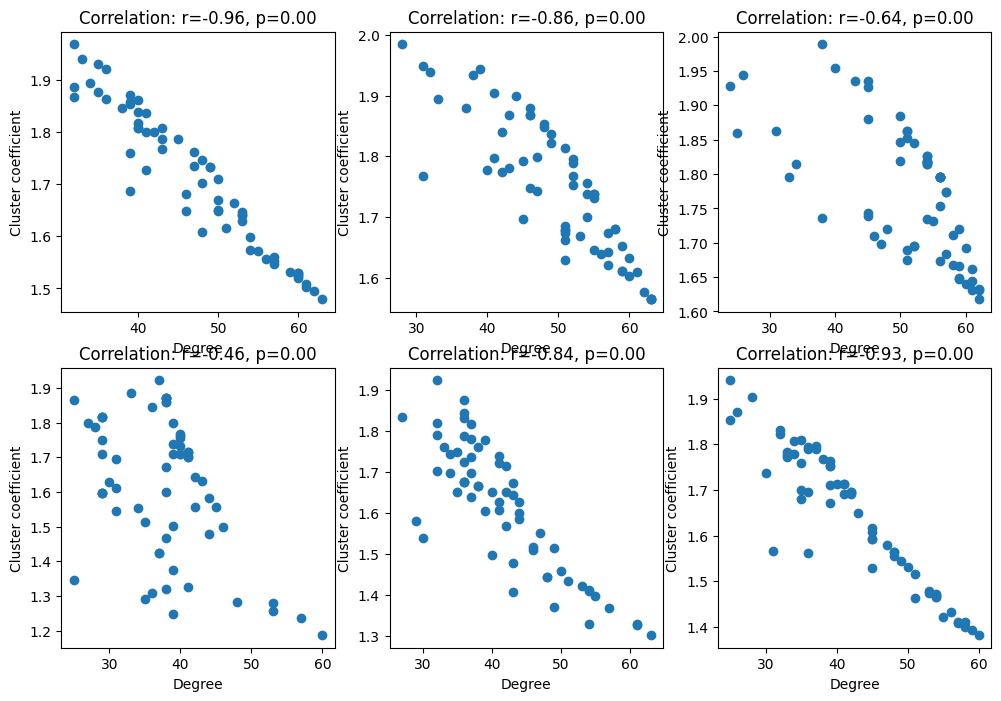

In [27]:
# Figure 31.10

freqs2plot = [5, 9]  # Hz
times2plot = [100, 200, 300]  # ms
clim = [0.4, 0.8]

# Open two figures ('h' for handle)
figh1 = plt.figure(figsize=(12, 8))
figh2 = plt.figure(figsize=(12, 8))

for fi, freq in enumerate(freqs2plot):
    for ti, time in enumerate(times2plot):
        # Frequency index
        fidx = np.argmin(np.abs(frex - freq))
        
        # Extract thresholded connectivity matrix
        connmat = tf_all2all[:, :, fidx, np.argmin(np.abs(times2save - time))]
        connmat = connmat + connmat.T  # Make symmetric matrix
        connmat = connmat > thresh[fidx]  # Threshold and binarize
        
        # Initialize
        clustcoef = np.zeros(EEG['nbchan'][0, 0])
        
        for chani in range(EEG['nbchan'][0, 0]):
            # Find neighbors (suprathreshold connections)
            neighbors = np.where(connmat[chani, :] > 0)[0]
            n = len(neighbors)
            
            # Cluster coefficient not computed for islands
            if n > 1:
                # "Local" network of neighbors
                localnetwork = connmat[np.ix_(neighbors, neighbors)]
                # Compute cluster coefficient (neighbor connectivity scaled)
                clustcoef[chani] = 2 * np.nansum(localnetwork) / (n * (n - 1))
        
        # Topoplots
        plt.figure(figh1.number)
        ax1 = plt.subplot(len(freqs2plot), len(times2plot), ti + 1 + fi * len(times2plot))
        plot_topomap(clustcoef, chanlocs, axes=ax1, show=False, cmap='jet')
        plt.title(f'Cluster coefficient: {time} ms, {freq} Hz')
        
        # Relationship between degree and cluster coefficient
        plt.figure(figh2.number)
        plt.subplot(len(freqs2plot), len(times2plot), ti + 1 + fi * len(times2plot))
        degree = np.sum(connmat > 0, axis=0)
        plt.scatter(degree, clustcoef)
        r, p = np.corrcoef(degree, clustcoef)[0, 1], 0  # Replace 0 with actual p-value calculation if needed
        # plt.ylim([-0.05, 1.05])
        # plt.xlim([0, 30])
        plt.xlabel('Degree')
        plt.ylabel('Cluster coefficient')
        plt.title(f'Correlation: r={r:.2f}, p={p:.2f}')

plt.show()

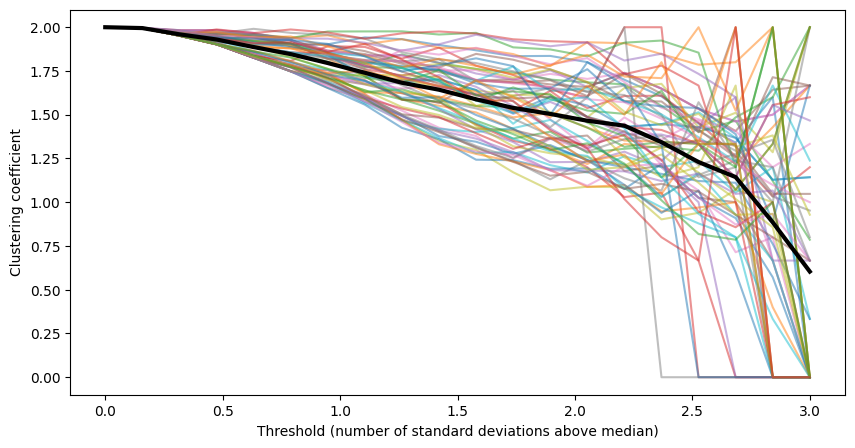

In [33]:
# Figure 31.11

thresholds = np.linspace(0, 3, 20)
clustercoefficients = np.zeros((EEG['nbchan'][0, 0], len(thresholds)))

for ti, thresh_val in enumerate(thresholds):
    # Find frequency index
    fidx = np.argmin(np.abs(frex - freqs2plot[0]))
    
    # Extract thresholded connectivity matrix
    connmat = tf_all2all[:, :, fidx, np.argmin(np.abs(times2save - times2plot[2]))]
    tmpsynch = tf_all2all[:, :, fidx, :].flatten()
    tthresh = np.median(tmpsynch) + thresh_val * np.std(tmpsynch)
    connmat = connmat + connmat.T  # Make symmetric matrix
    connmat = connmat > tthresh  # Threshold and binarize
    
    for chani in range(EEG['nbchan'][0, 0]):
        # Find neighbors (suprathreshold connections)
        neighbors = np.where(connmat[chani, :] > 0)[0]
        n = len(neighbors)
        
        # Cluster coefficient not computed for islands
        if n > 1:
            # "Local" network of neighbors
            localnetwork = connmat[np.ix_(neighbors, neighbors)]
            # Compute cluster coefficient (neighbor connectivity scaled)
            clustercoefficients[chani, ti] = 2 * np.nansum(localnetwork) / (n * (n - 1))

plt.figure(figsize=(10, 5))
plt.plot(thresholds, clustercoefficients.T, alpha=0.5)
plt.plot(thresholds, np.mean(clustercoefficients, axis=0), 'k', linewidth=3)
plt.xlabel('Threshold (number of standard deviations above median)')
plt.ylabel('Clustering coefficient')
# plt.ylim([-0.025, 1.025])
plt.show()

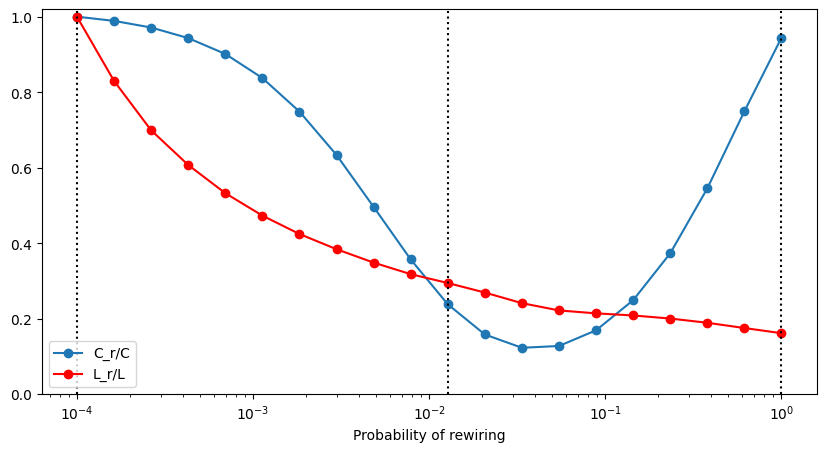

In [48]:
# Figures 31.13/14 (this cell takes a long time to run...)

use_real_network = False  # if False, simulate a network (True/False for Figures 13/14)

freq2use = 10
time2use = 100

# Frequency index
fidx = np.argmin(np.abs(frex - freq2use))

connmat = tf_all2all[:, :, fidx, np.argmin(np.abs(times2save - time2use))]
connmat = connmat + connmat.T  # Make symmetric matrix
connmat = connmat > thresh[fidx]  # Threshold and binarize

if not use_real_network:
    n = 1000  # number of nodes
    k = 10  # neighbor connectivity
    connmat = np.zeros((n, n))
    for i in range(n):
        # set neighbors to 1 (special cases for start and end of network)
        connmat[i, max(1, i - k // 2):min(n, i + k // 2)] = 1

# probabilities of rewiring
probs = np.logspace(np.log10(0.0001), np.log10(1), 20)

cp = np.zeros(len(probs))
lp = np.zeros(len(probs))

# loop over a few networks to make plots look a bit nicer
for neti in range(10):
    for probi, prob in enumerate(probs):
        # rewire
        # find which edges to rewire
        real_edges = np.tril_indices_from(connmat, k=-1)
        num_edges_to_rewire = int(round(prob * len(real_edges[0])))
        edges_to_rewire = np.random.choice(len(real_edges[0]), size=num_edges_to_rewire, replace=False)
        
        # rewired connectivity matrix
        connmat_rewired = connmat.copy()
        
        # loop through edges and change target
        for edge_idx in edges_to_rewire:
            # find XY coordinates
            x, y = real_edges[0][edge_idx], real_edges[1][edge_idx]
            
            # find possible edges to change (cannot already be an edge)
            edges2change = np.where(connmat_rewired[x, :] == 0)[0]
            
            # rewire
            y2rewire = np.random.choice(edges2change, 1)
            connmat_rewired[x, y2rewire] = 1
            connmat_rewired[y2rewire, x] = 1
            
            # set original to zero
            connmat_rewired[x, y] = 0
            connmat_rewired[y, x] = 0
        
        # mirror matrix
        connmat_rewired = np.tril(connmat_rewired) + np.tril(connmat_rewired).T
        
        # compute cluster coefficient and path lengths
        G = nx.from_numpy_array(connmat_rewired)
        clustcoef_rewired = nx.average_clustering(G)
        
        # Handle disconnected graph by considering the largest connected component
        if nx.is_connected(G):
            pathlength_rewired = nx.average_shortest_path_length(G)
        else:
            # Get the largest connected component
            largest_cc = max(nx.connected_components(G), key=len)
            subgraph = G.subgraph(largest_cc)
            pathlength_rewired = nx.average_shortest_path_length(subgraph)
        
        cp[probi] += clustcoef_rewired
        lp[probi] += pathlength_rewired

cp /= neti
lp /= neti

plt.figure(figsize=(10, 5))
plt.plot(probs, cp / cp[0], '-o', label='C_r/C')
plt.plot(probs, lp / lp[0], 'r-o', label='L_r/L')
plt.xlabel('Probability of rewiring')
plt.legend()
plt.xscale('log')
plt.axvline(probs[0], color='k', linestyle=':')
plt.axvline(probs[10], color='k', linestyle=':')
plt.axvline(probs[-1], color='k', linestyle=':')
plt.ylim([0, 1.02])
plt.show()

/var/folders/6s/__zkn53s2bg90cyp78pt9zgm0000gn/T/ipykernel_4970/998331856.py:41: RuntimeWarning: invalid value encountered in scalar divide
  swn_z[threshi] = (swn_real - np.mean(swn_permutations)) / np.std(swn_permutations)


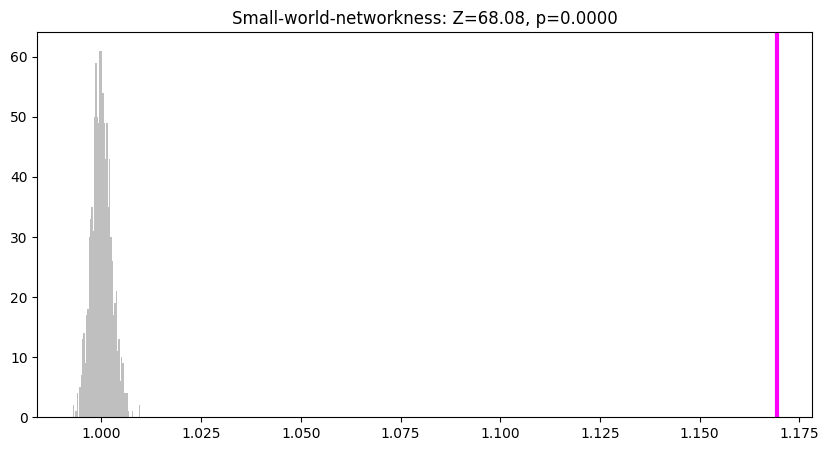

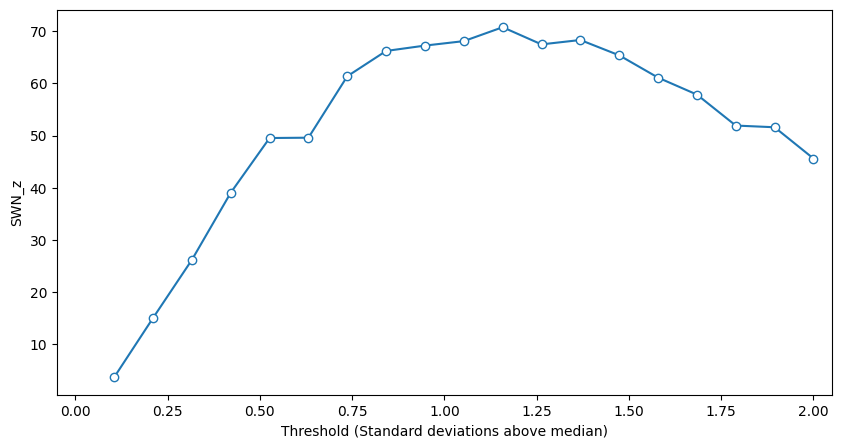

In [50]:
# Figures 31.15/16

freq2use = 6
time2use = 300
n_permutations = 1000

thresholds = np.linspace(0, 2, 20)
swn_z = np.zeros(len(thresholds))

for threshi, thresh_val in enumerate(thresholds):
    # Frequency index
    fidx = np.argmin(np.abs(frex - freq2use))
    
    connmat = tf_all2all[:, :, fidx, np.argmin(np.abs(times2save - time2use))]
    tmpsynch = tf_all2all[:, :, fidx, :].flatten()
    tthresh = np.median(tmpsynch) + thresh_val * np.std(tmpsynch)
    connmat = connmat + connmat.T  # Make symmetric matrix
    connmat = connmat > tthresh  # Threshold and binarize
    nconnections = np.sum(connmat) // 2  # Number of connections (for random network)
    
    # Compute real cluster coefficient and path lengths
    G_real = nx.from_numpy_array(connmat)
    clustcoef_real = nx.average_clustering(G_real)
    pathlengths_real = nx.average_shortest_path_length(G_real)
    
    # Generate random graphs and compute their CC and PL
    clustercoefficients_random = np.zeros(n_permutations)
    pathlengths_random = np.zeros(n_permutations)
    
    for permi in range(n_permutations):
        # Generate random network...
        G_random = nx.gnm_random_graph(len(connmat), nconnections)
        clustercoefficients_random[permi] = nx.average_clustering(G_random)
        pathlengths_random[permi] = nx.average_shortest_path_length(G_random)
    
    # Compute permuted small-world-network-ness
    swn_permutations = (clustercoefficients_random / np.mean(clustercoefficients_random)) / (pathlengths_random / np.mean(pathlengths_random))
    
    # True swn and its z-value
    swn_real = (clustcoef_real / np.mean(clustercoefficients_random)) / (pathlengths_real / np.mean(pathlengths_random))
    swn_z[threshi] = (swn_real - np.mean(swn_permutations)) / np.std(swn_permutations)
    
    if threshi == len(thresholds) // 2:
        plt.figure(figsize=(10, 5))
        plt.hist(swn_permutations, bins=50, alpha=0.5, color='gray')
        plt.axvline(swn_real, color='magenta', linewidth=3)
        plt.title(f'Small-world-networkness: Z={swn_z[threshi]:.2f}, p={1 - norm.cdf(np.abs(swn_z[threshi])):.4f}')
        plt.show()

plt.figure(figsize=(10, 5))
plt.plot(thresholds, swn_z, '-o', markerfacecolor='white')
plt.xlabel('Threshold (Standard deviations above median)')
plt.ylabel('SWN_z')
plt.xlim([-0.05, 2.05])
plt.show()